# STATS 607
## Week 7: Probabilistic programming and neural density estimation

## Probabilistic programming language (PPL)

> A probabilistic programming language (PPL) is a programming language or framework designed to describe probabilistic models and automate inference over them. It provides high-level constructs for defining random variables, probabilistic dependencies, and likelihood functions, making it easier to implement and test statistical models without explicitly coding complex inference algorithms.

## Example from original Stan paper

- $\theta \sim \mathrm{Beta}(1, 1)$.
- $y_i \sim \mathrm{Bernoulli}(\theta)$
- Goal: infer $\theta$. Equivalently, sample from $p(\theta \mid y)$.

```
for (n in 1:N)
  y[n] ~ bernoulli(theta);
  
data {
  int<lower=0> N; int<lower=0, upper=1> y[N];
}

parameters {
  real<lower=0, upper=1> theta; 
}

model {
  // N >= 0
  // y[n] in { 0, 1 }
  // theta in [0, 1]
  theta ~ beta(1, 1); // prior
  y ~ bernoulli(theta); // likelihood
}
```

## Options for sampling
If we want to sample from $p(\theta \mid y)$ we have a few options:
 
- Directly: not unless you are lucky :-)
- Inverse transform ($F^{-1}(U)$): univariate, requires inverting CDF.
- Rejection sampling: good for low dimensions.
- MCMC:
  - Metropolis-Hastings
  - Slice sampling
  - Gibbs sampling
  - Hamiltonian Monte-Carlo/Langevin dynamics
  - VI
  
So the fundamental thing is being able to compute $\log p(\theta, y)$ and/or its gradient.

## Let's build a PPL
Let's build a simple class structure that will enable inference.

In [405]:
import dataclasses

def jax_dataclass(cls):
    d = dataclasses.dataclass(cls, frozen=True, order=True)
    return jax.tree_util.register_dataclass(d, data_fields=['params'], meta_fields=[]) 

In [406]:
import jax


@jax_dataclass
class RandomVariable:
    params: tuple
        
    def log_p(self, x):
        pass

In [407]:
import jax
import jax.scipy as jsp
import jax.numpy as jnp

@jax_dataclass
class Beta(RandomVariable):        
    def log_p(self, x):
        a, b = self.params
        return jsp.stats.beta.logpdf(x, a, b)

In [408]:
@jax_dataclass
class Bernoulli(RandomVariable):       
    def log_p(self, x):
        p, = self.params
        return jnp.select(
            [x == 0, x == 1],
            [jnp.log1p(-p), jnp.log(p)],
            -jnp.inf
        )

In [358]:
class Model:
    def __init__(self):
        self._vars = {}
    
    def add_var(self, name: str, var: RandomVariable):
        self._vars[name] = var
        
    def name_of(self, var: RandomVariable):
        return next(name for name, v in self._vars.items() if v is var)
        
    def log_p(self, values: dict[str, float]) -> float:
        ret = 0.
        for name, var in self._vars.items():
            bound_params = ()
            for p in var.params:
                if isinstance(p, RandomVariable):
                    p = values[self.name_of(p)] 
                bound_params += (p,)
            val = values[name]
            ret += dataclasses.replace(var, params=bound_params).log_p(val)
        return ret

In [359]:
m = Model()
theta = Beta((1., 1.))
m.add_var('theta', theta)
for i in range(100):
    m.add_var(f'y_{i}', Bernoulli((theta,)))

In [360]:
p = 0.7
data = {f'y_{i}': int(x < p) for i, x in enumerate(np.random.rand(n))}
data['theta'] = 0.3

m.log_p(data)

Array(-85.658005, dtype=float32, weak_type=True)

## Implementing a sampling algorithm
Let's start basic:

In [361]:
from typing import Callable
from jax.random import PRNGKey, split

def sample_mh(m: Model,
              proposal: Callable[[ParamsDict, PRNGKey], ParamsDict], 
              x0: ParamsDict, 
              key: PRNGKey,
              niter: int = 1000) -> list[ParamsDict]:
    x = x0
    lp = m.log_p(x)
    ret = []
    naccept = 0
    
    for _ in range(niter):
        key, subkey0, subkey1 = split(key, 3)
        x_prime = proposal(x, subkey0)
        lpp = m.log_p(x_prime)
        y = lp - lpp
        if jax.random.exponential(subkey1) > y:
            x = x_prime
            lp = lpp
            naccept += 1
        ret.append(x)
        
    print("accept rate: ", naccept / niter)
    return ret

In [362]:
def proposal(d: ParamsDict, key):
    return {**d, 'theta': jax.random.beta(key, 1., 1.)}

In [363]:
res = sample_mh(m, proposal, data, PRNGKey(1))

accept rate:  0.181


(array([ 28.,  97., 262., 264., 241.,  94.,   8.,   0.,   5.,   1.]),
 array([0.46672869, 0.50226307, 0.53779745, 0.57333189, 0.60886627,
        0.64440066, 0.67993504, 0.71546942, 0.75100386, 0.78653824,
        0.82207263]),
 <BarContainer object of 10 artists>)

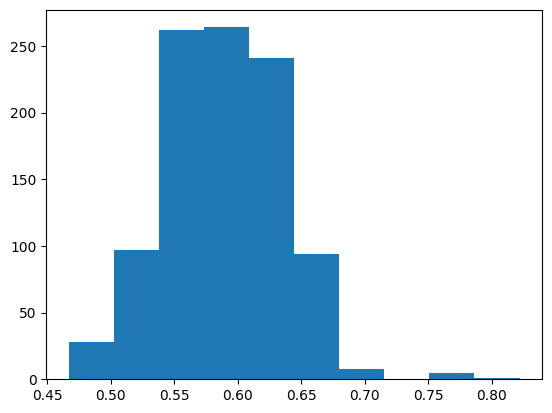

In [364]:
import matplotlib.pyplot as plt
plt.hist([k['theta'] for k in res])

accept rate:  0.181


(array([ 28.,  97., 262., 264., 241.,  94.,   8.,   0.,   5.,   1.]),
 array([0.46672869, 0.50226307, 0.53779745, 0.57333189, 0.60886627,
        0.64440066, 0.67993504, 0.71546942, 0.75100386, 0.78653824,
        0.82207263]),
 <BarContainer object of 10 artists>)

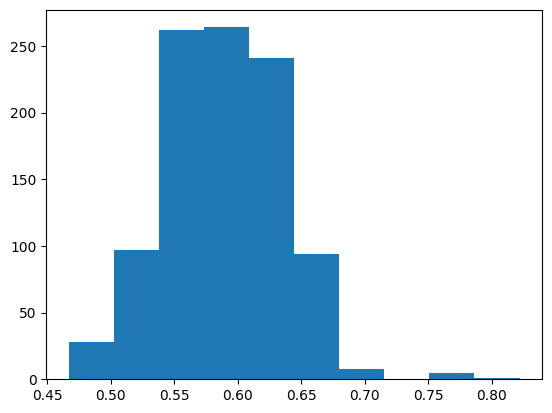

In [365]:
from jax import lax

def sample_mh(m: Model,
              proposal: Callable[[ParamsDict, PRNGKey], ParamsDict], 
              x0: ParamsDict, 
              key: PRNGKey,
              niter: int = 1000) -> list[ParamsDict]:
   
    def f(accum, _):
        key, x, lp, naccept = accum
        key, subkey0, subkey1 = split(key, 3)
        x_prime = proposal(x, subkey0)
        lpp = m.log_p(x_prime)
        y = lp - lpp
        accept = jax.random.exponential(subkey1) > y
        x, lp = jax.tree.map(lambda a, b: jnp.where(accept, a, b), (x_prime, lpp), (x, lp))
        naccept += accept
        return (key, x, lp, naccept), x
    
    init = (key, x0, m.log_p(x0), 0)
    (_, _, _, naccept), ret = lax.scan(f, init, length=niter)
    print("accept rate: ", naccept / niter)
    return ret

res = sample_mh(m, proposal, data, PRNGKey(1))
plt.hist(res['theta'])

## Langevin dynamics

In [366]:
from jax import grad

grad(log_p)(d)

ValueError: Comparator raised exception while sorting pytree dictionary keys.

In [374]:
def f(th):
    d = {**data, 'theta': th}
    return m.log_p(d)

grad(f)(0.1)

Array(544.44434, dtype=float32, weak_type=True)

In [381]:
def sample_langevin(
    log_density: Callable,
    x0: ParamsDict, 
    key: PRNGKey,
    step_size: float = 0.1,
    niter: int = 1000) -> list[ParamsDict]:
   
    def f(accum, _):
        key, x = accum
        g = grad(log_density)(x)
        key, subkey = jax.random.split(key)
        noise = jax.random.normal(subkey, shape=x.shape)
        x_prime = x + 0.5 * step_size * g + jnp.sqrt(step_size) * noise
        return (key, x_prime), x_prime
    
    init = (key, x0)
    _, ret = lax.scan(f, init, length=niter)
    return ret

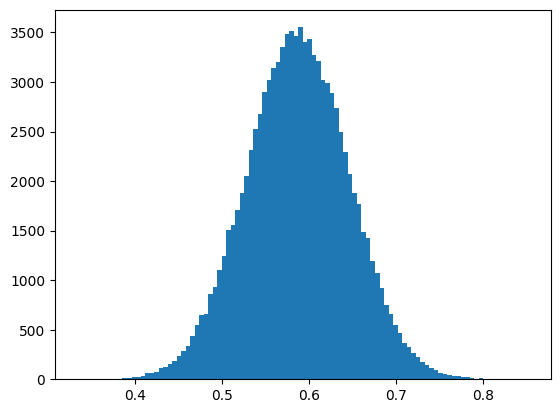

In [395]:
res = sample_langevin(f, 0.9, jax.random.PRNGKey(10), step_size=.003, niter=100000)
plt.hist(res, bins=100);

In [472]:
class LogitBijector:
    @staticmethod
    def forward(x):
        return jax.scipy.special.expit(y)

    @staticmethod
    def backward(y):
        return jax.scipy.special.logit(x)
    
    @staticmethod
    def log_det_jac(y):
        return -(jnp.log(y) + jnp.log1p(-y))
    
def transform(rv, bij):
    class TransformedRV:
        def log_p(self, x):
            y = bij.backward(x)
            log_q = rv.log_p(y)
            # Adjust for change of variables
            log_det_jac = bij.log_det_jac(x)
            return log_q - log_det_jac
    return TransformedRV()

In [473]:
@jax_dataclass
class Normal(RandomVariable):
    def log_p(self, x):
        mu, sigma = self.params
        return jax.scipy.stats.norm.logpdf(x, mu, sigma)

z = Normal((0, 1.))
pos = transform(z, LogitBijector)
pos.log_p(.5)

Array([       -inf, -12.816197 ,  -9.838501 ,  -8.310896 ,  -7.3220224,
        -6.608991 ,  -6.0613346,  -5.6228075,  -5.2611294,  -4.956182 ,
        -4.694643 ,  -4.4672713,  -4.2674165,  -4.090145 ,  -3.9317083,
        -3.789195 ,  -3.6603055,  -3.5431933,  -3.4363575,  -3.338562 ,
        -3.2487803,  -3.1661494,  -3.0899405,  -3.019531 ,  -2.9543881,
        -2.8940508,  -2.8381195,  -2.7862458,  -2.738125 ,  -2.693489 ,
        -2.6521015,  -2.6137543,  -2.5782614,  -2.5454593,  -2.5152023,
        -2.48736  ,  -2.4618177,  -2.4384727,  -2.4172335,  -2.3980198,
        -2.3807604,  -2.3653927,  -2.351862 ,  -2.3401208,  -2.3301294,
        -2.3218534,  -2.3152652,  -2.310343 ,  -2.3070705,  -2.305437 ,
        -2.305437 ,  -2.3070705,  -2.310343 ,  -2.3152654,  -2.3218534,
        -2.3301294,  -2.3401208,  -2.351862 ,  -2.3653927,  -2.3807604,
        -2.3980198,  -2.4172335,  -2.4384725,  -2.4618177,  -2.48736  ,
        -2.5152023,  -2.5454595,  -2.5782614,  -2.613754 ,  -2.6

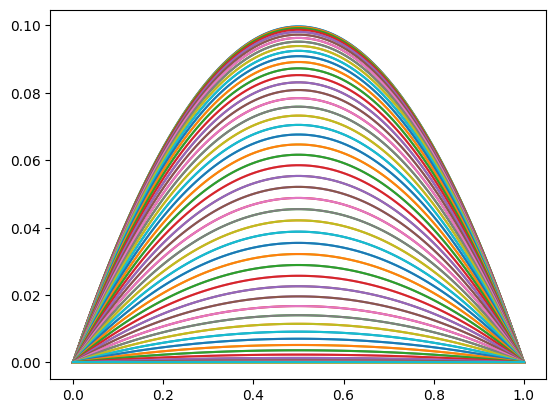

In [474]:
x = np.linspace(0., 1., 100)
y = jax.vmap(pos.log_p)(x)
plt.plot(x, np.exp(y))

In [475]:
from scipy.integrate import quad
quad(jax.jit(lambda x: jnp.exp(pos.log_p(x))), 0., 1.)

TypeError: Only scalar arrays can be converted to Python scalars; got arr.ndim=1